# CSX46 Class Session 18: Markov Clustering

In today's notebook we will analyze a small network described in a file `test.dot` in an edge-list format called `dot` (from the GraphViz command-line toolset for graph visualization, which can be accessed from python using the `pygraphviz` python package). We will implement a Markov clustering algorithm and run it on the graph.

In [10]:
import pygraphviz
import igraph
import numpy
import pandas
import csv

Use the static clsas method `pygrahpviz.AGraph` to load the file `shared/test.dot` and return an object of class `pygraphviz.agraph.AGraph` containing an undirected graph.

In [2]:
test_graph = pygraphviz.AGraph("shared/test.dot")
type(test_graph)

pygraphviz.agraph.AGraph

Get the set of edges (as a list of pairlists) using the `pygraphviz.agraph.AGraph.edges()` method

In [3]:
edges = test_graph.edges()
edges[0:5]

[('1', '2'), ('1', '6'), ('1', '7'), ('2', '7'), ('2', '4')]

Make an `igraph.Graph` object from the `edges` list using the static method `igraph.Graph.TupleList()`:

In [4]:
test_igraph = igraph.Graph.TupleList(edges)
test_igraph.summary()

'IGRAPH UN-- 13 26 -- \n+ attr: name (v)'

Draw a plot of the graph using the function `igraph.drawing.plot()`. Use the `igraph.Graph.vs()` to get a VertexSet and index into it using `name`; that will give you a list of vertex names to pass to the `plot` function as argument `vertex_label`. How many distinct network communities do you expect to get from Markov clustering?

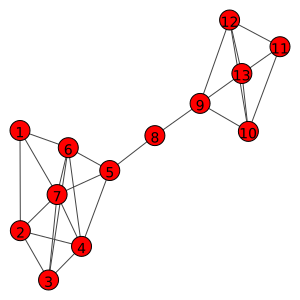

In [5]:
igraph.drawing.plot(test_igraph, bbox=[0, 0, 300, 300], vertex_label=test_igraph.vs()['name'])

Now the fun part. Implement a markov cluster function!

In [7]:
def markov_cluster(graph):
    # you will need to construct an adjacency matrix; use the get_adjacency() method and then 
    # reference the '.data' attribute of the object (of class igraph.datatypes.Matrix) 
    # that was returned from `get_adjacency()`.
    adj_mat = numpy.matrix(graph.get_adjacency().data)
    
    # need to know the number of vertices; use shape (and indexing to element zero) to get that
    N = adj_mat.shape[0]
    
    # you will need to compute the vertex degrees as a numpy array
    vertex_degrees = numpy.array(graph.degree())
    
    # make a transition matrix in two steps:
    # first, compute the sum of the adjacency matrix and a parity matrix
    #   (the parity matrix can be made using using numpy.diag)
    # second, compute the inverse of the vertex_degrees diagonal matrix using numpy.diag
    #   and numpy.inalg.inv (inverse should always exist b/c we assume the graph is void-free)
    trans_mat_new = (adj_mat + numpy.diag([1]*N)) * numpy.linalg.inv(numpy.diag(vertex_degrees + 1))
    
    # initialize the "current" transition matrix as all zeros
    trans_mat = numpy.zeros([N, N])
    
    # set an iteration counter to zero; we will hard-code a max of 20 iterations below
    iter_count = 0
    
    # while the fractional change in the transition matrix (by Frobenius norm) is less than 0.01 and
    # iterations is less than 20....
    
        # note: use numpy.linalg.norm(    , ord="fro"); we are going to compute this norm for the difference
        # _and_ for the average of the current transition matrix and the new transition matrix; compute the ratio
        
    while ((numpy.linalg.norm(trans_mat_new - trans_mat, ord="fro")/
        numpy.linalg.norm(0.5*(trans_mat_new + trans_mat), ord="fro")) > 0.01 and iter_count < 20):
        
        # assign the new transition matrix to be the current transition matrix
        trans_mat = trans_mat_new
        
        # apply the expansion step with r=2, using numpy.linalg.matrix_power(   , 2)
        trans_mat_new = numpy.linalg.matrix_power(trans_mat_new, 2)
        
        # note: trans_mat_new is still a left stochastic matrix (you can check it to be sure)
        
        # now apply the inflation step with s=2, using numpy.power(  , 2)
        trans_mat_new = numpy.power(trans_mat_new, 2)
        
        # compute column sums using numpy.sum(   , axis=0)
        column_sums = numpy.sum(trans_mat_new, axis=0)
        
        # make a matrix of the column sums using numpy.repeat(    , N, axis=0); call it trans_mat_div
        trans_mat_div = numpy.repeat(column_sums, N, axis=0)
        
        # normalize the inflated matrix by element_wise dividing by trans_mat_div using numpy.divide
        trans_mat_new = numpy.divide(trans_mat_new, trans_mat_div)
        
        # increment the iteration counter
        iter_count += 1
        print("just completed iteration: " + str(iter_count))
        
    # threshold the transition matrix at 1e-10, into a binary matrix (containing only 0 or 1 in each element)
    trans_mat_new[trans_mat_new < 1e-10]=0
    trans_mat_new[trans_mat_new > 1e-10]=1
    
    # take the transpose matrix and make a data frame out of it
    trans_mat_df = pandas.DataFrame(trans_mat_new.transpose())
    
    # each row is a "signature" corresponding to a specific cluster; drop duplicate rows
    cluster_signatures = trans_mat_df.drop_duplicates()
    
    # count the clusters and assign a numeric cluster ID to each cluster, by setting the `index` variable
    cluster_signatures.index=range(cluster_signatures.shape[0])
    
    # use pandas.merge to compute the index for each signature in the original matrix (before you dropped duplicates)
    # - make sure to call reset_index on each of the data frames that you are passing to merge
    # - in the merge call, for the left_on argument, specify the columns of cluster_signatures (list format)
    # - in the marge call, for the right_on argument, specify the columns of trans_mat_df (list_format)
    merged_df = pandas.merge(cluster_signatures.reset_index(),
                 trans_mat_df.reset_index(),
                 left_on=cluster_signatures.columns.tolist(),
                 right_on=trans_mat_df.columns.tolist())
    
    # return the "index_x" column of merged_df, in list format
    return(merged_df["index_x"].tolist())
    

Run your code on test_igraph and print the results!  How many iterations did it take?  Do the clusters make sense?

In [8]:
markov_cluster(test_igraph)

just completed iteration: 1
just completed iteration: 2
just completed iteration: 3
just completed iteration: 4
just completed iteration: 5
just completed iteration: 6
just completed iteration: 7
just completed iteration: 8
just completed iteration: 9


[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2]

Now see if you can load in a larger graph (from the Krogan et al. paper) in edge-list (SIF) format. Load the file `shared/krogan.sif` using pandas.read_csv(). Run the graph through your `markov_cluster` code. How many clusters do you get? What is the histogram of cluster sizes?

In [11]:
df = pandas.read_csv("shared/krogan.sif", 
                     sep="\t", 
                     quoting=csv.QUOTE_NONE,
                     names=["species1","species2"])


In [12]:
df.head()

species1 species2
0     AAC3     PMR1
1     AAP1     GUD1
2     AAP1    TRS31
3     AAP1     GCN3
4     AAP1     MDY2

In [15]:
krogan_graph = igraph.Graph.TupleList(df.values.tolist())
krogan_graph.summary()

'IGRAPH UN-- 2674 7079 -- \n+ attr: name (v)'

In [16]:
clust_ids = markov_cluster(krogan_graph)

just completed iteration: 1
just completed iteration: 2
just completed iteration: 3
just completed iteration: 4
just completed iteration: 5
just completed iteration: 6
just completed iteration: 7
just completed iteration: 8
just completed iteration: 9
just completed iteration: 10
just completed iteration: 11
just completed iteration: 12


In [32]:
max(clust_ids)

650

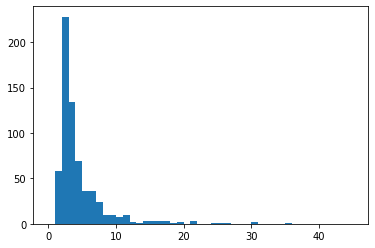

In [31]:
from matplotlib import pyplot as plt
import collections
counts = [count for count in dict(collections.Counter(clust_ids)).values()]
bins = numpy.array(range(0, max(counts)))
plt.hist(counts, bins=bins)
plt.show()